# Analysis of MA AR ARMA Models and best selection criteria

## Importing the relevant packages

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
# from pmdarima.arima import auto_arima
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')


## Importing the Data and Pre-processing 

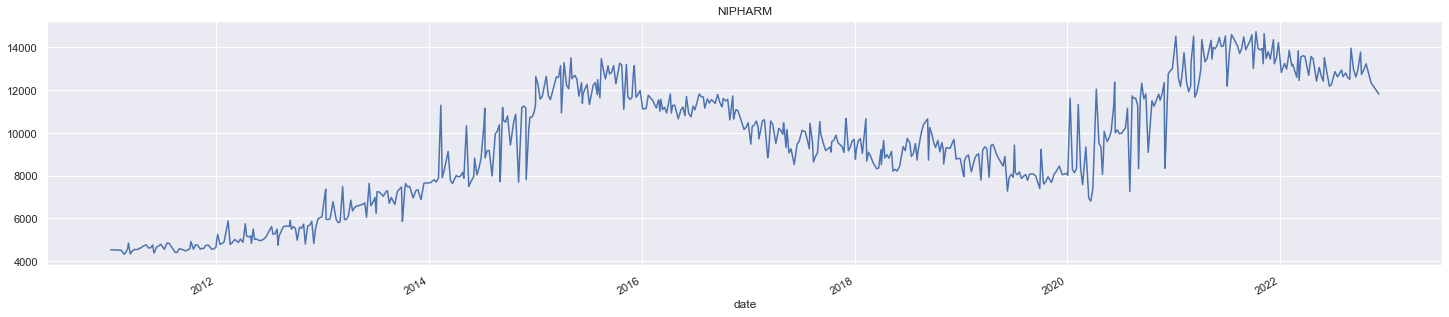

In [174]:
raw_csv_data = pd.read_csv(r"D:\Arjun 2\Coding Files-Arjun\Computer Science\Finance\Time Series\Time Series Analysis Python\My Files\Nifty Pharma Historical Data - Weekly.csv") 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst= True) # dd/mm/yyy format
df.set_index('date', inplace= True) # set date as the index 

df_nipharm = df.copy()
df_nipharm['market_value'] = df['price']

df_nipharm.market_value.plot(figsize= (25,5), title = "NIPHARM")
plt.show()
df_nipharm.drop(df.columns[1], axis = 1, inplace=True)

In [175]:
df_nipharm.head()

,price,market_value
date,,
2011-01-05,4539.25,4539.25
2011-02-10,4518.40,4518.40
2011-02-13,4463.25,4463.25
2011-02-20,4328.10,4328.10
2011-02-27,4446.75,4446.75


In [176]:
df_nipharm.tail()

,price,market_value
date,,
2022-10-07,12732.00,12732.00
2022-10-16,12979.40,12979.40
2022-10-23,13228.05,13228.05
2022-11-09,12346.85,12346.85
2022-12-06,11803.95,11803.95


## Checking how the data is distributed
### In other words, about 96% of the throughput time series data follows a normal distribution. The other 4% are scattered outliers at both ends.
### Sci.probplot Generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default).

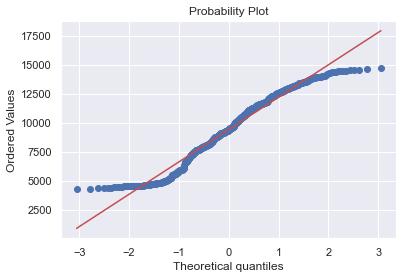

In [177]:
import scipy.stats as sci
import pylab

sci.probplot(df_nipharm.market_value, plot = pylab)
pylab.show()

## The LLR Test
- The LR test compares the log likelihoods of a model with values of the parameter a constrained to some value (in our example zero) to a model where a is freely estimated.
- The Likelihood-Ratio Test (LRT) is a statistical test used to compare the goodness of fit of two models based on the ratio of their likelihoods.

In [178]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p




# Custom Return fucntion
def returns(df,lags):
    df['returns'] = df.market_value.pct_change(lags).mul(100)
    df_new = df.iloc[lags:]
    df_ret = df.returns.iloc[lags:]
    return df_ret, df_new

# Custom ADF test
def adfuller_test(sales):
    result= sts.adfuller(sales)
    labels=['ADF test: ','p-value: ','Lags Used: ']
    for value,label in zip(result,labels):
        print(label +":"+str(value))
    
    if result[1]<=.05:
        print("reject null hypothesis (h0)\nUnit root does not exist\nSeries is stationary")
    else:
        print("fail to reject null hypothesis(h0)\nUnit root exists\nSeriesis not sationary")

# Custom normalization function
def norm(df):
    benchmark = df.returns.iloc[0]
    df_norm = df.returns.div(benchmark).mul(100)
    df['norm'] = df.returns.div(benchmark).mul(100)
    


## Creating Returns

In [179]:
df_ret, df_nipharm_ret = returns(df_nipharm,1)
df_nipharm_ret

,price,market_value,returns
date,,,
2011-02-10,4518.40,4518.40,-0.459327
2011-02-13,4463.25,4463.25,-1.220565
2011-02-20,4328.10,4328.10,-3.028063
2011-02-27,4446.75,4446.75,2.741388
2011-03-04,4587.95,4587.95,3.175353
...,...,...,...
2022-10-07,12732.00,12732.00,-7.556588
2022-10-16,12979.40,12979.40,1.943135
2022-10-23,13228.05,13228.05,1.915728


## Normalised returns

In [180]:
norm(df_nipharm_ret)
df_nipharm_ret

,price,market_value,returns,norm
date,,,,
2011-02-10,4518.40,4518.40,-0.459327,100.000000
2011-02-13,4463.25,4463.25,-1.220565,265.728958
2011-02-20,4328.10,4328.10,-3.028063,659.238981
2011-02-27,4446.75,4446.75,2.741388,-596.827051
2011-03-04,4587.95,4587.95,3.175353,-691.305522
...,...,...,...,...
2022-10-07,12732.00,12732.00,-7.556588,1645.143546
2022-10-16,12979.40,12979.40,1.943135,-423.039683
2022-10-23,13228.05,13228.05,1.915728,-417.072821


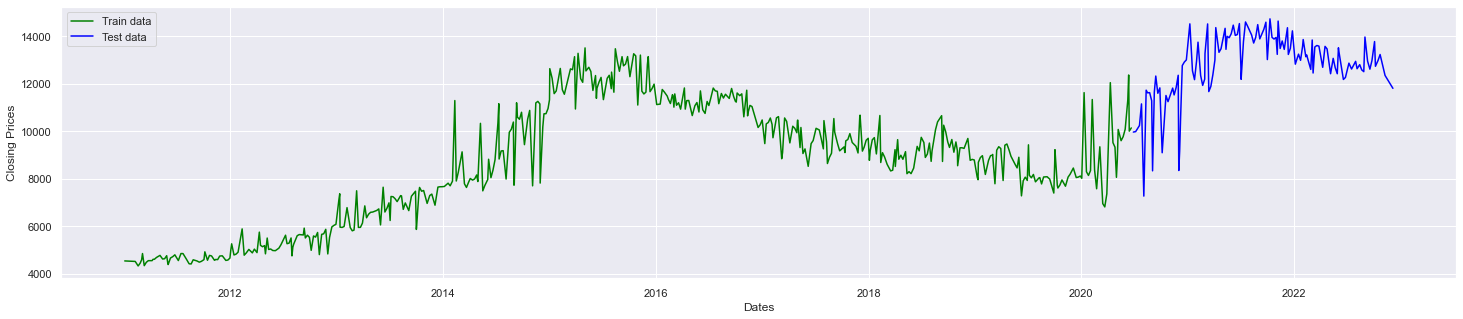

In [181]:
train_len = round(len(df_nipharm)*0.8)
test_len = round(len(df_nipharm)*0.2)

df_nipharm_test = df_nipharm.iloc[train_len:]
df_nipharm_train = df_nipharm.iloc[:train_len]

plt.figure(figsize=(25,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_nipharm_train.market_value, 'green', label='Train data')
plt.plot(df_nipharm_test.market_value, 'blue', label='Test data')
plt.legend()

# Training Testing
df_full = df_nipharm_ret
df_nipharm_ret_test = df_nipharm_ret.iloc[train_len:]


In [182]:
df_nipharm_ret.tail()

,price,market_value,returns,norm
date,,,,
2022-10-07,12732.00,12732.00,-7.556588,1645.143546
2022-10-16,12979.40,12979.40,1.943135,-423.039683
2022-10-23,13228.05,13228.05,1.915728,-417.072821
2022-11-09,12346.85,12346.85,-6.661602,1450.296182
2022-12-06,11803.95,11803.95,-4.397073,957.286011


In [183]:
df_nipharm_ret_test.head()


,price,market_value,returns,norm
date,,,,
2020-07-06,9982.80,9982.80,0.194713,-42.390858
2020-07-19,10237.95,10237.95,2.555896,-556.443720
2020-07-26,11148.90,11148.90,8.897777,-1937.133621
2020-08-03,7268.00,7268.00,-34.809712,7578.416593
2020-08-11,11726.45,11726.45,61.343561,-13355.096327


In [184]:
df_nipharm_ret_test.tail()

,price,market_value,returns,norm
date,,,,
2022-10-07,12732.00,12732.00,-7.556588,1645.143546
2022-10-16,12979.40,12979.40,1.943135,-423.039683
2022-10-23,13228.05,13228.05,1.915728,-417.072821
2022-11-09,12346.85,12346.85,-6.661602,1450.296182
2022-12-06,11803.95,11803.95,-4.397073,957.286011


## Checking for Stationarity
 Sationarity
 - Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time.
 - Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

In [185]:
adfuller_test(df_nipharm_ret.returns)

ADF test: :-3.3506081281129028
p-value: :0.012762388044307025
Lags Used: :19
reject null hypothesis (h0)
Unit root does not exist
Series is stationary


In [186]:
adfuller_test(df_nipharm_ret.norm)

ADF test: :-3.3506081281130027
p-value: :0.012762388044303125
Lags Used: :19
reject null hypothesis (h0)
Unit root does not exist
Series is stationary


<AxesSubplot:ylabel='Density'>

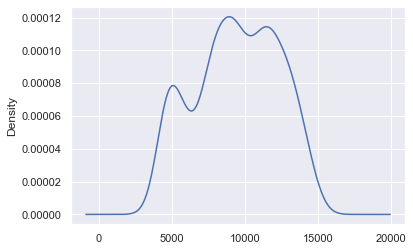

In [187]:
#Distribution of the dataset
df_close = df_nipharm['price']
df_close.plot(kind='kde')

<Figure size 432x288 with 0 Axes>

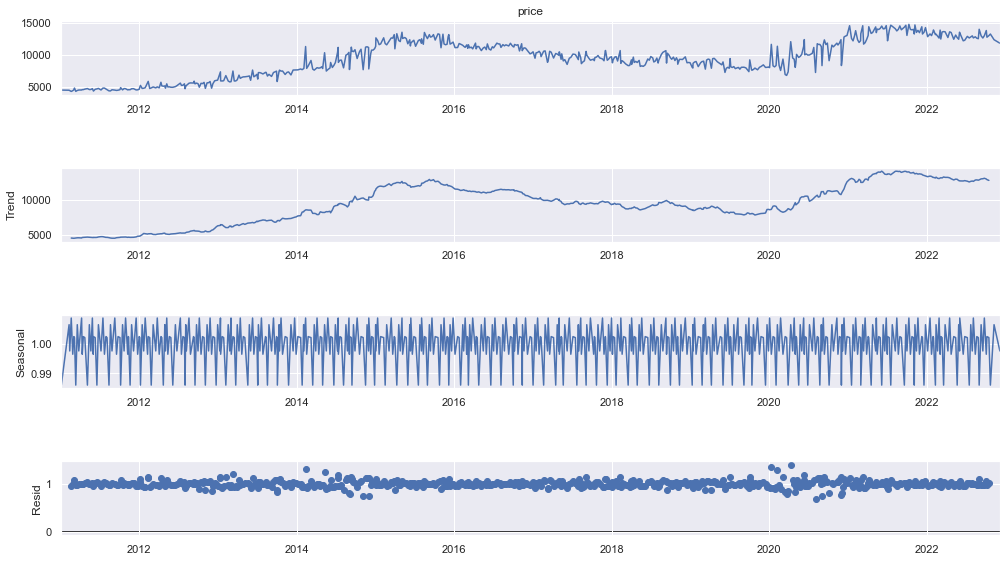

In [188]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 7)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Autocorrelation 
- It is the correlation of a signal with a delayed copy — or a lag — of itself as a function of the delay. When plotting the value of the ACF for increasing lags (a plot called a correlogram), the values tend to degrade to zero quickly for stationary time series, while for non-stationary data the degradation will happen more slowly.

## ACF/PACF for Returns
## Autocorrelation Function (ACF)
- Autocorrelation is the correlation between a time series with a lagged version of itself. 
- The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
- We can plot an ACF graph by using the plot_acf function as shown below

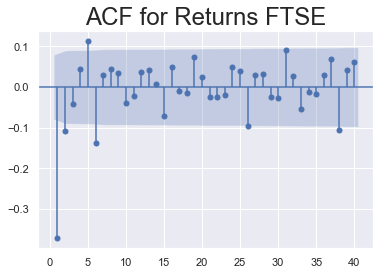

In [189]:
sgt.plot_acf(df_nipharm_ret.norm, zero = False, lags = 40)
plt.title("ACF for Returns FTSE", size = 24)
plt.show()

## Partical Autocorrelation Function (PACF)
- In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. 
- It contrasts with the autocorrelation function, which does not control for other lags.  This function plays an important role in data analysis aimed at identifying the extent of the lag in an autoregressive (AR) model.

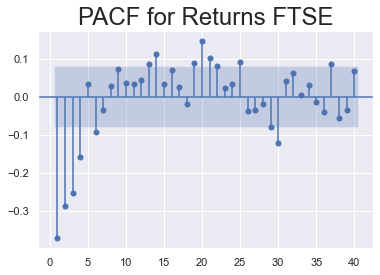

In [190]:
sgt.plot_pacf(df_nipharm_ret.norm, zero = False, lags = 40)
plt.title("PACF for Returns FTSE", size = 24)
plt.show()

# Moving Average (MA)
- In time series analysis, the moving-average model (MA model), also known as moving-average process, is a common approach for modeling univariate time series. 
- The moving-average model specifies that the output variable is cross-correlated with a non-identical to itself random-variable.

## MA(q) for Returns

In [191]:
model_ret_ma1 = ARMA(df_nipharm_ret.norm, order = (0,1))
results_ret_ma1 = model_ret_ma1.fit()

# Using the ACF graph we can determine that the 4th lag is significant
model_ret_ma4 = ARMA(df_nipharm_ret.norm, order = (0,4))
results_ret_ma4 = model_ret_ma4.fit()
print(results_ret_ma4.summary())

print("\nLLR test p-value = " + str(LLR_test(model_ret_ma1, model_ret_ma4)))


                              ARMA Model Results                              
Dep. Variable:                   norm   No. Observations:                  611
Model:                     ARMA(0, 4)   Log Likelihood               -5469.993
Method:                       css-mle   S.D. of innovations           1868.818
Date:                Sat, 05 Nov 2022   AIC                          10951.986
Time:                        00:28:50   BIC                          10978.477
Sample:                             0   HQIC                         10962.290
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -143.4193     28.888     -4.965      0.000    -200.038     -86.800
ma.L1.norm    -0.6090      0.040    -15.143      0.000      -0.688      -0.530
ma.L2.norm    -0.1186      0.049     -2.407      0.0

## Residual Analysis

In [192]:
import math
df_nipharm_ret['res_ret_ma4'] = results_ret_ma4.resid
print(f"Mean: {df_nipharm_ret.res_ret_ma4.mean()}")
print(f"Variance: {df_nipharm_ret.res_ret_ma4.var()}")
print(f"Standard Deviation: {round(math.sqrt(df_nipharm_ret.res_ret_ma4.var()), 4)}")

Mean: 1.2307284978799078
Variance: 3498480.97370274
Standard Deviation: 1870.4227


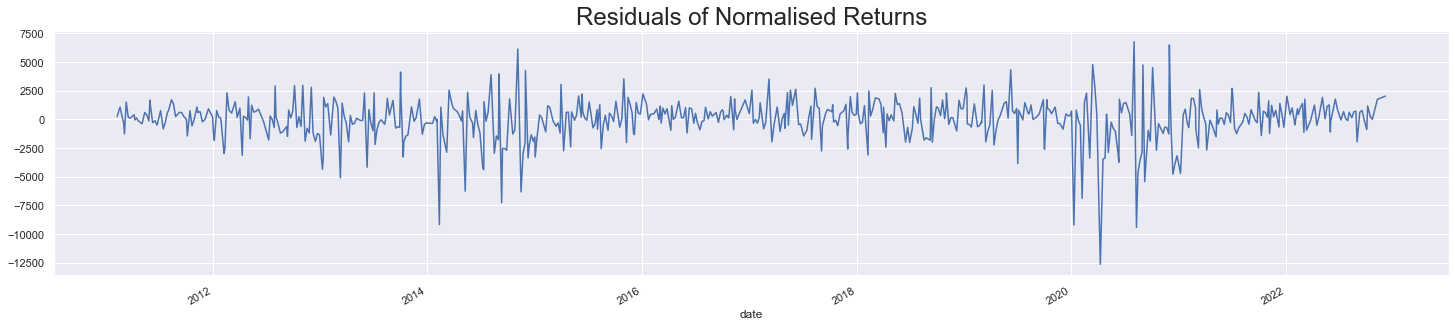

In [193]:
df_nipharm_ret.res_ret_ma4.plot(figsize=(25,5))
plt.title("Residuals of Normalised Returns",size=24)
plt.show()

In [194]:
# Checking for stationarity of residuals
adfuller_test(df_nipharm_ret.res_ret_ma4)

ADF test: :-2.5857377462438795
p-value: :0.09598095864742767
Lags Used: :19
fail to reject null hypothesis(h0)
Unit root exists
Seriesis not sationary


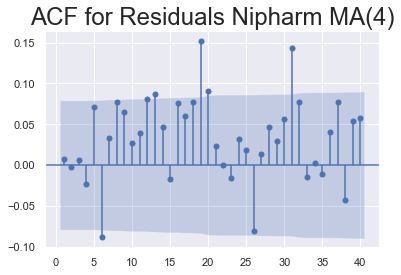

In [195]:
sgt.plot_acf(df_nipharm_ret.res_ret_ma4, zero = False, lags = 40)
plt.title("ACF for Residuals Nipharm MA(4)", size = 24)
plt.show()

### Explain above result simply

# Auto Regressive (AR)
- In a multiple regression model, we forecast the variable of interest using a linear combination of predictors. In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. 
- The term autoregression indicates that it is a regression of the variable against itself.

![](https://miro.medium.com/max/1100/1%2AleVNdf2HTIZbPjb5Fi3PZQ.webp)

## AR(p) for Returns

In [196]:
model_ret_ar1 = ARMA(df_nipharm_ret.norm, order = (1,0))
results_ret_ar1 = model_ret_ar1.fit()

# Using PACF we see that 4th lag is significant
model_ret_ar4 = ARMA(df_nipharm_ret.norm, order = (4,0))
results_ret_ar4 = model_ret_ar4.fit()
print(results_ret_ar4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ar1, model_ret_ar4)))

                              ARMA Model Results                              
Dep. Variable:                   norm   No. Observations:                  611
Model:                     ARMA(4, 0)   Log Likelihood               -5469.240
Method:                       css-mle   S.D. of innovations           1866.547
Date:                Sat, 05 Nov 2022   AIC                          10950.481
Time:                        00:28:53   BIC                          10976.971
Sample:                             0   HQIC                         10960.785
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -143.4624     29.498     -4.863      0.000    -201.278     -85.647
ar.L1.norm    -0.5922      0.040    -14.821      0.000      -0.671      -0.514
ar.L2.norm    -0.4734      0.045    -10.635      0.0

## Residual Analysis

In [197]:
import math
df_nipharm_ret['res_ret_ar4'] = results_ret_ar4.resid
print(f"Mean: {df_nipharm_ret.res_ret_ar4.mean()}")
print(f"Variance: {df_nipharm_ret.res_ret_ar4.var()}")
print(f"Standard Deviation: {round(math.sqrt(df_nipharm_ret.res_ret_ar4.var()), 4)}")

Mean: 1.492232172523829
Variance: 3489968.943109438
Standard Deviation: 1868.1459


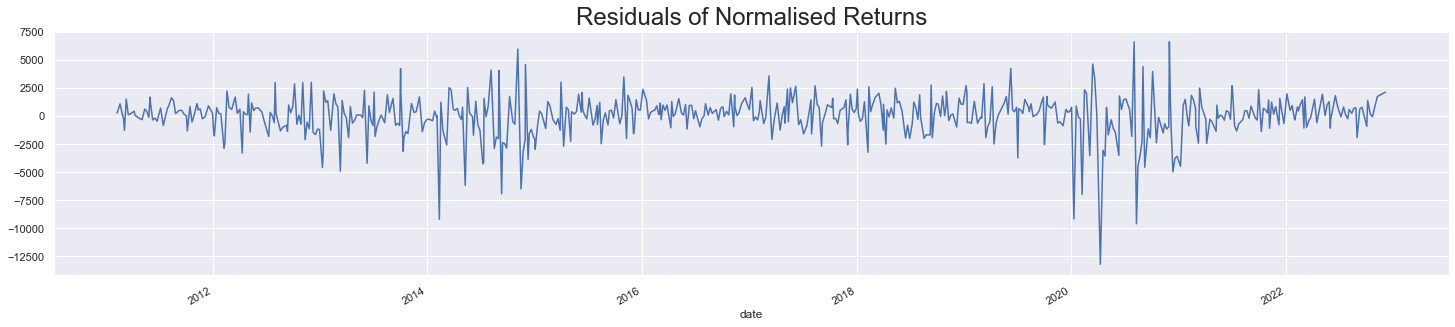

In [198]:
df_nipharm_ret.res_ret_ar4.plot(figsize=(25,5))
plt.title("Residuals of Normalised Returns",size=24)
plt.show()

In [199]:
# Checking for stationarity of residuals
adfuller_test(df_nipharm_ret.res_ret_ar4)

ADF test: :-2.604267423721294
p-value: :0.09211848145539187
Lags Used: :19
fail to reject null hypothesis(h0)
Unit root exists
Seriesis not sationary


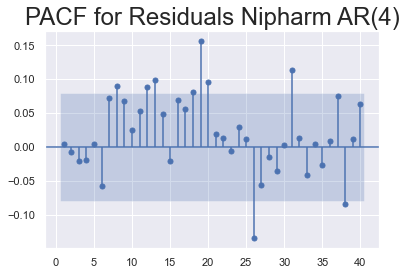

In [200]:
sgt.plot_pacf(df_nipharm_ret.res_ret_ar4, zero = False, lags = 40)
plt.title("PACF for Residuals Nipharm AR(4)", size = 24)
plt.show()

# Autoregressive Moving Average model (ARMA)
An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

- p is the order of the autoregressive polynomial,
- q is the order of the moving average polynomial.

![](https://www.statisticshowto.com/wp-content/uploads/2018/09/arma.jpeg)

In [201]:
model_ret_ar4_ma4 = ARMA(df_nipharm_ret.norm, order = (4,4))
results_ret_ar4_ma4 = model_ret_ar4_ma4.fit(start_ar_lags=1)
print(results_ret_ar4_ma4.summary())


                              ARMA Model Results                              
Dep. Variable:                   norm   No. Observations:                  611
Model:                     ARMA(4, 4)   Log Likelihood               -5454.074
Method:                       css-mle   S.D. of innovations           1814.038
Date:                Sat, 05 Nov 2022   AIC                          10928.147
Time:                        00:29:00   BIC                          10972.298
Sample:                             0   HQIC                         10945.320
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -140.8120     57.296     -2.458      0.014    -253.111     -28.513
ar.L1.norm     0.1097      0.050      2.191      0.028       0.012       0.208
ar.L2.norm     0.0450      0.024      1.891      0.0

## Residual Analysis of the ARMA(4,4)

In [202]:
df_nipharm_ret['res_ret_ar4_ma4'] = results_ret_ar4_ma4.resid
print(f"Mean: {df_nipharm_ret.res_ret_ar4_ma4.mean()}")
print(f"Variance: {df_nipharm_ret.res_ret_ar4_ma4.var()}")
print(f"Standard Deviation: {round(math.sqrt(df_nipharm_ret.res_ret_ar4_ma4.var()), 4)}")

Mean: 1.7314124762246441
Variance: 3314864.192140367
Standard Deviation: 1820.6769


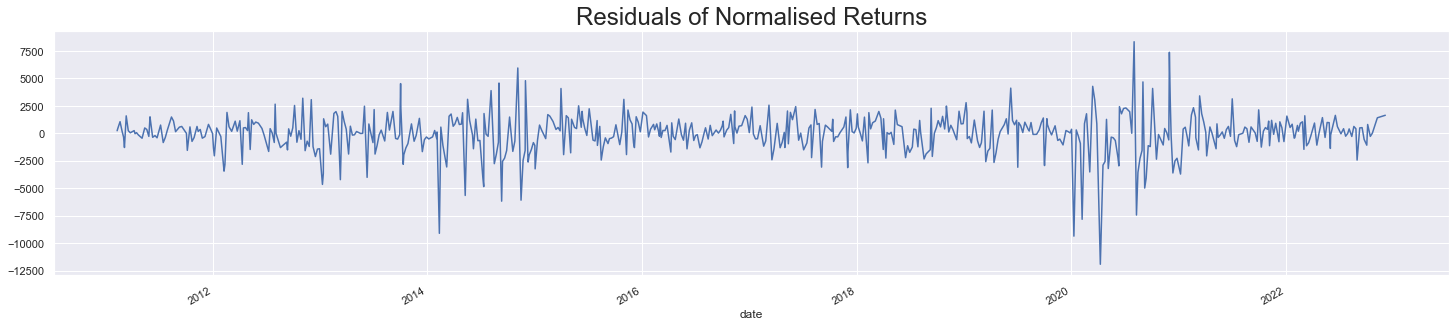

In [203]:
df_nipharm_ret.res_ret_ar4_ma4.plot(figsize=(25,5))
plt.title("Residuals of Normalised Returns",size=24)
plt.show()

In [204]:
adfuller_test(df_nipharm_ret.res_ret_ar4_ma4)

ADF test: :-24.46914316339708
p-value: :0.0
Lags Used: :0
reject null hypothesis (h0)
Unit root does not exist
Series is stationary


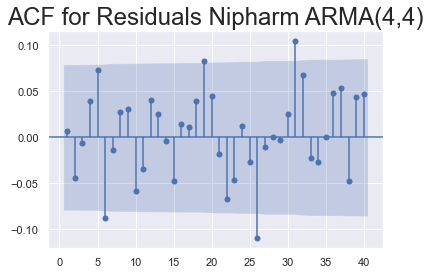

In [205]:
sgt.plot_acf(df_nipharm_ret.res_ret_ar4_ma4, zero = False, lags = 40)
plt.title("ACF for Residuals Nipharm ARMA(4,4)", size = 24)
plt.show()

## P&C of the 

In [206]:

print("4, 3")
model_ret_ar4_ma3 = ARMA(df_nipharm_ret.norm, order=(4,3))
results_ret_ar4_ma3 = model_ret_ar4_ma3.fit()
print(results_ret_ar4_ma3.summary())
print("\n\n")

print("3, 4")
model_ret_ar3_ma4 = ARMA(df_nipharm_ret.norm, order=(3,4))
results_ret_ar3_ma4 = model_ret_ar3_ma4.fit()
print(results_ret_ar3_ma4.summary())
print("\n\n")

print("-----------------------------------------------------------------------------------------")

print("3, 3")
model_ret_ar3_ma3 = ARMA(df_nipharm_ret.norm, order=(3,3))
results_ret_ar3_ma3 = model_ret_ar3_ma3.fit()
print(results_ret_ar3_ma3.summary())
print("\n\n")

print("4, 2")
model_ret_ar4_ma2 = ARMA(df_nipharm_ret.norm, order=(4,2))
results_ret_ar4_ma2 = model_ret_ar4_ma2.fit(start_ar_lags=1)
print(results_ret_ar4_ma2.summary())
print("\n\n")

print("2, 4")
model_ret_ar2_ma4 = ARMA(df_nipharm_ret.norm, order=(2,4))
results_ret_ar2_ma4 = model_ret_ar2_ma4.fit()
print(results_ret_ar2_ma4.summary())
print("\n\n")

print("-----------------------------------------------------------------------------------------")

print("1, 4")
model_ret_ar1_ma4 = ARMA(df_nipharm_ret.norm, order=(1,4))
results_ret_ar1_ma4 = model_ret_ar1_ma4.fit()
print(results_ret_ar1_ma4.summary())
print("\n\n")

print("4, 1")
model_ret_ar4_ma1 = ARMA(df_nipharm_ret.norm, order=(4,1))
results_ret_ar4_ma1 = model_ret_ar4_ma1.fit()
print(results_ret_ar4_ma1.summary())
print("\n\n")

print("3, 2")
model_ret_ar3_ma2 = ARMA(df_nipharm_ret.norm, order=(3,2))
results_ret_ar3_ma2 = model_ret_ar3_ma2.fit()
print(results_ret_ar3_ma2.summary())
print("\n\n")

print("2, 3")
model_ret_ar2_ma3 = ARMA(df_nipharm_ret.norm, order=(2,3))
results_ret_ar2_ma3 = model_ret_ar2_ma3.fit()
print(results_ret_ar2_ma3.summary())
print("\n\n")

print("-----------------------------------------------------------------------------------------")
print("2, 2")
model_ret_ar2_ma2 = ARMA(df_nipharm_ret.norm, order=(2,2))
results_ret_ar2_ma2 = model_ret_ar2_ma2.fit()
print(results_ret_ar2_ma2.summary())
print("\n\n")

print("3, 1")
model_ret_ar3_ma1 = ARMA(df_nipharm_ret.norm, order=(3,1))
results_ret_ar3_ma1 = model_ret_ar3_ma1.fit()
print(results_ret_ar3_ma1.summary())
print("\n\n")

print("1, 3")
model_ret_ar1_ma3 = ARMA(df_nipharm_ret.norm, order=(1,3))
results_ret_ar1_ma3 = model_ret_ar1_ma3.fit()
print(results_ret_ar1_ma3.summary())
print("\n\n")

print("-----------------------------------------------------------------------------------------")
print("2, 1")
model_ret_ar2_ma1 = ARMA(df_nipharm_ret.norm, order=(2,1))
results_ret_ar2_ma1 = model_ret_ar2_ma1.fit()
print(results_ret_ar2_ma1.summary())
print("\n\n")

print("1, 2")
model_ret_ar1_ma2 = ARMA(df_nipharm_ret.norm, order=(1,2))
results_ret_ar1_ma2 = model_ret_ar1_ma2.fit()
print(results_ret_ar1_ma2.summary())
print("\n\n")

print("-----------------------------------------------------------------------------------------")
print("1, 1")
model_ret_ar1_ma1 = ARMA(df_nipharm_ret.norm, order=(1,1))
results_ret_ar1_ma1 = model_ret_ar1_ma1.fit()
print(results_ret_ar1_ma1.summary())
print("\n\n")

4, 3
                              ARMA Model Results                              
Dep. Variable:                   norm   No. Observations:                  611
Model:                     ARMA(4, 3)   Log Likelihood               -5466.987
Method:                       css-mle   S.D. of innovations           1859.608
Date:                Sat, 05 Nov 2022   AIC                          10951.973
Time:                        00:29:03   BIC                          10991.709
Sample:                             0   HQIC                         10967.429
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -143.5934     28.057     -5.118      0.000    -198.585     -88.602
ar.L1.norm    -0.9610      0.186     -5.172      0.000      -1.325      -0.597
ar.L2.norm    -0.8365      0.228     -3.667    

In [207]:
print("ARMA(3,3): \tLL = ", results_ret_ar3_ma3.llf, "\tAIC = ", results_ret_ar3_ma3.aic)
print("ARMA(1,3): \tLL = ", results_ret_ar1_ma3.llf, "\tAIC = ", results_ret_ar1_ma3.aic)
print("ARMA(3,1): \tLL = ", results_ret_ar3_ma1.llf, "\tAIC = ", results_ret_ar3_ma1.aic)
print("ARMA(2,2): \tLL = ", results_ret_ar2_ma2.llf, "\tAIC = ", results_ret_ar2_ma2.aic)
print("ARMA(2,3): \tLL = ", results_ret_ar2_ma3.llf, "\tAIC = ", results_ret_ar2_ma3.aic)


ARMA(3,3): 	LL =  -5467.201416682466 	AIC =  10950.402833364931
ARMA(1,3): 	LL =  -5457.51351218182 	AIC =  10927.02702436364
ARMA(3,1): 	LL =  -5470.564286440139 	AIC =  10953.128572880278
ARMA(2,2): 	LL =  -5458.025134402926 	AIC =  10928.050268805851
ARMA(2,3): 	LL =  -5467.3368960642365 	AIC =  10948.673792128473


In [208]:
print("ARMA(3,3): \tLL = ", results_ret_ar3_ma3.llf, "\tAIC = ", results_ret_ar3_ma3.aic)
print("ARMA(1,3): \tLL = ", results_ret_ar1_ma3.llf, "\tAIC = ", results_ret_ar1_ma3.aic)

ARMA(3,3): 	LL =  -5467.201416682466 	AIC =  10950.402833364931
ARMA(1,3): 	LL =  -5457.51351218182 	AIC =  10927.02702436364


In [209]:
print(LLR_test(model_ret_ar1_ma3, model_ret_ar3_ma3, DF =2))

1.0


## Residuals Analysis

In [210]:
df_nipharm_ret['res_ret_ar1_ma3'] = results_ret_ar1_ma3.resid
print(f"Mean: {df_nipharm_ret.res_ret_ar1_ma3.mean()}")
print(f"Variance: {df_nipharm_ret.res_ret_ar1_ma3.var()}")
print(f"Standard Deviation: {round(math.sqrt(df_nipharm_ret.res_ret_ar1_ma3.var()), 4)}")

Mean: -2.156566021664313
Variance: 3355059.3190584
Standard Deviation: 1831.6821


In [211]:
adfuller_test(df_nipharm_ret.res_ret_ar1_ma3)

ADF test: :-10.28362446084706
p-value: :3.723782359733363e-18
Lags Used: :5
reject null hypothesis (h0)
Unit root does not exist
Series is stationary


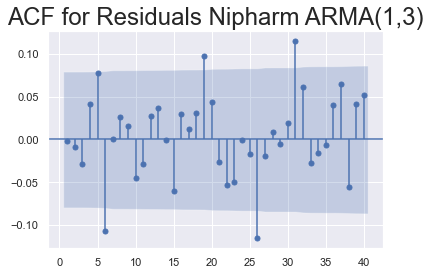

In [212]:
sgt.plot_acf(df_nipharm_ret.res_ret_ar1_ma3, zero = False, lags = 40)
plt.title("ACF for Residuals Nipharm ARMA(1,3)", size = 24)
plt.show()

## ARMA Revised

In [213]:
print("1, 5")
model_ret_ar1_ma5= ARMA(df_nipharm_ret.norm, order=(1,5))
results_ret_ar1_ma5 = model_ret_ar1_ma5.fit(start_ar_lags=6)
print(results_ret_ar1_ma5.summary())
print("\n\n")

print("ARMA(1,5): \tLL = ", results_ret_ar1_ma5.llf, "\tAIC = ", results_ret_ar1_ma5.aic)
print("ARMA(1,3): \tLL = ", results_ret_ar1_ma3.llf, "\tAIC = ", results_ret_ar1_ma3.aic)

1, 5
                              ARMA Model Results                              
Dep. Variable:                   norm   No. Observations:                  611
Model:                     ARMA(1, 5)   Log Likelihood               -5466.545
Method:                       css-mle   S.D. of innovations           1858.202
Date:                Sat, 05 Nov 2022   AIC                          10949.089
Time:                        00:29:21   BIC                          10984.410
Sample:                             0   HQIC                         10962.828
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -143.3114     29.701     -4.825      0.000    -201.525     -85.098
ar.L1.norm    -0.6098      0.181     -3.361      0.001      -0.965      -0.254
ma.L1.norm     0.0210      0.180      0.117    

In [214]:
df_nipharm_ret['res_ret_ar1_ma5'] = results_ret_ar1_ma5.resid
print(f"Mean: {df_nipharm_ret.res_ret_ar1_ma5.mean()}")
print(f"Variance: {df_nipharm_ret.res_ret_ar1_ma5.var()}")
print(f"Standard Deviation: {round(math.sqrt(df_nipharm_ret.res_ret_ar1_ma5.var()), 4)}")

Mean: 1.286861454544926
Variance: 3458901.756213784
Standard Deviation: 1859.8123


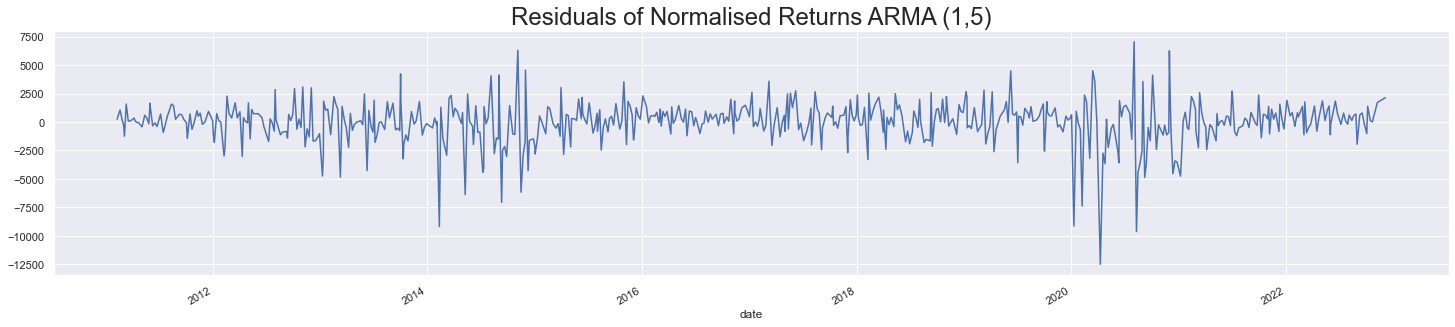

In [215]:
df_nipharm_ret.res_ret_ar1_ma5.plot(figsize=(25,5))
plt.title("Residuals of Normalised Returns ARMA (1,5)",size=24)
plt.show()

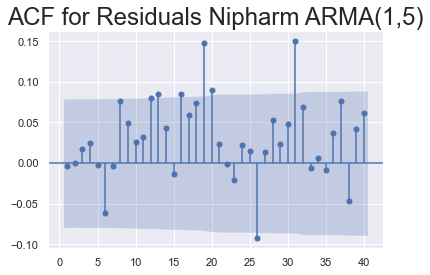

In [216]:
sgt.plot_acf(df_nipharm_ret.res_ret_ar1_ma5, zero = False, lags = 40)
plt.title("ACF for Residuals Nipharm ARMA(1,5)", size = 24)
plt.show()

In [218]:
df_nipharm_ret

,price,market_value,returns,norm,res_ret_ma4,res_ret_ar4,res_ret_ar4_ma4,res_ret_ar1_ma3,res_ret_ar1_ma5
date,,,,,,,,,
2011-02-10,4518.40,4518.40,-0.459327,100.000000,243.419280,243.462351,240.812033,237.088693,243.311410
2011-02-13,4463.25,4463.25,-1.220565,265.728958,502.516534,499.837200,502.491175,492.784631,497.848146
2011-02-20,4328.10,4328.10,-3.028063,659.238981,1071.065998,1068.664998,1066.666637,1063.741248,1057.038166
2011-02-27,4446.75,4446.75,2.741388,-596.827051,232.835142,218.715045,189.796812,182.696181,191.419909
2011-03-04,4587.95,4587.95,3.175353,-691.305522,-283.517853,-258.194689,-334.342652,-320.235927,-247.664288
...,...,...,...,...,...,...,...,...,...
2022-10-07,12732.00,12732.00,-7.556588,1645.143546,1177.215891,1367.220428,811.860468,799.233513,1384.099563
2022-10-16,12979.40,12979.40,1.943135,-423.039683,237.807585,160.735582,-272.332365,-34.332480,115.534095
2022-10-23,13228.05,13228.05,1.915728,-417.072821,5.977351,-78.229340,19.844639,-219.442663,13.725137


## Predictions using the Models chosen

<AxesSubplot:xlabel='date'>

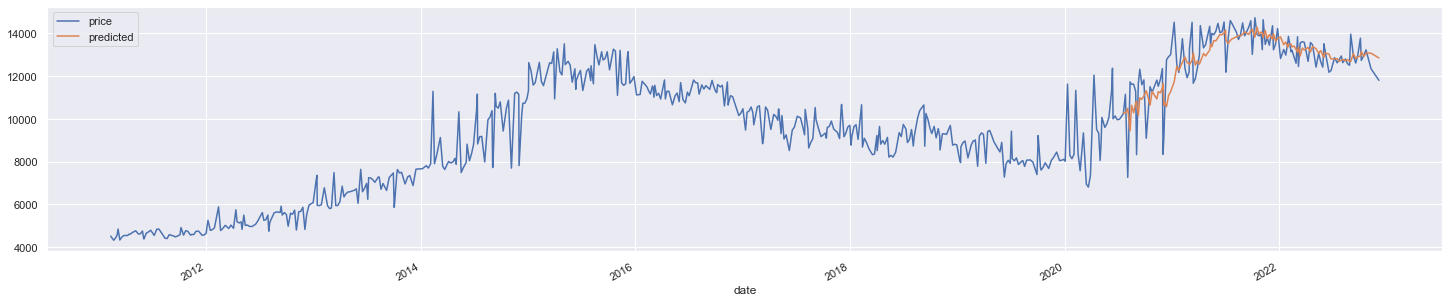

In [219]:
start_date = "2020-06-28"
end_date = "2022-12-06"
model_ar1_ma3 = ARIMA(df_nipharm_ret.price, order = (1,0,3))
results_ar1_ma3  = model_ar1_ma3.fit()

df_nipharm_ret['predicted'] = results_ar1_ma3.predict(start = 491, end = 610)
df_nipharm_ret[['price','predicted']].plot(figsize=(25,5))


<AxesSubplot:xlabel='date'>

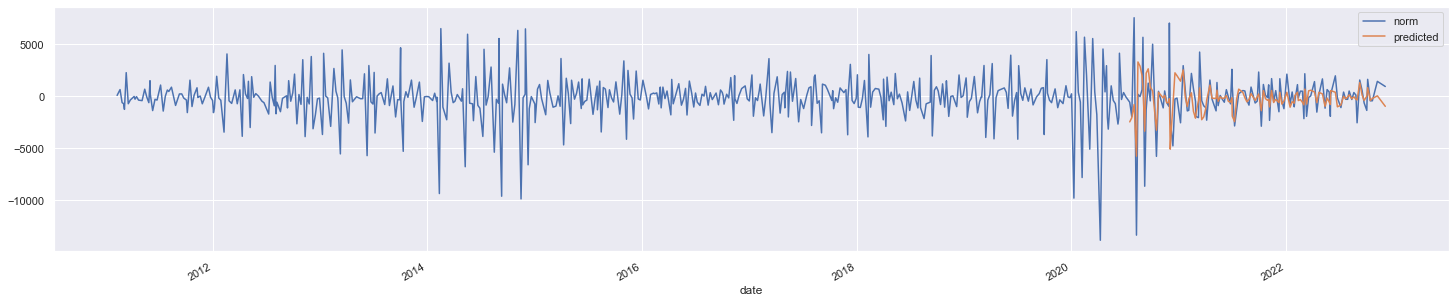

In [220]:
model_ar1_ma3 = ARIMA(df_nipharm_ret.norm, order = (1,0,3))
results_ar1_ma3  = model_ar1_ma3.fit()

df_nipharm_ret['predicted'] = results_ar1_ma3.predict(start = 491, end = 610)
df_nipharm_ret[['norm','predicted']].plot(figsize=(25,5))

In [221]:
prediction_index = pd.date_range(start='2022-12-06', periods=49, freq='W',name='datetime_utc')
prediction_index

DatetimeIndex(['2022-12-11', '2022-12-18', '2022-12-25', '2023-01-01',
               '2023-01-08', '2023-01-15', '2023-01-22', '2023-01-29',
               '2023-02-05', '2023-02-12', '2023-02-19', '2023-02-26',
               '2023-03-05', '2023-03-12', '2023-03-19', '2023-03-26',
               '2023-04-02', '2023-04-09', '2023-04-16', '2023-04-23',
               '2023-04-30', '2023-05-07', '2023-05-14', '2023-05-21',
               '2023-05-28', '2023-06-04', '2023-06-11', '2023-06-18',
               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',
               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',
               '2023-08-20', '2023-08-27', '2023-09-03', '2023-09-10',
               '2023-09-17', '2023-09-24', '2023-10-01', '2023-10-08',
               '2023-10-15', '2023-10-22', '2023-10-29', '2023-11-05',
               '2023-11-12'],
              dtype='datetime64[ns]', name='datetime_utc', freq='W-SUN')

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(df_nipharm_ret.price, order = (1, 0, 3), seasonal_order=(0,2,2,12),enforce_stationarity=False,enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit()
SARIMAXmodel.bic

SARIMAXmodel_Trend = SARIMAX(df_nipharm_ret.price, order = (1, 0, 3),enforce_stationarity=False,enforce_invertibility=False)
SARIMAXmodel_Trend = SARIMAXmodel_Trend.fit()


In [231]:
y_pred = SARIMAXmodel.get_forecast(len(prediction_index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = prediction_index
y_pred_out = y_pred_df["Predictions"] 

y_pred_2 = SARIMAXmodel_Trend.get_forecast(len(prediction_index))
y_pred_df_2 = y_pred_2.conf_int(alpha = 0.05) 
y_pred_df_2["TrendLine"] = SARIMAXmodel_Trend.predict(start = y_pred_df_2.index[0], end = y_pred_df_2.index[-1])
y_pred_df_2.index = prediction_index
y_pred_out_2 = y_pred_df_2["TrendLine"] 

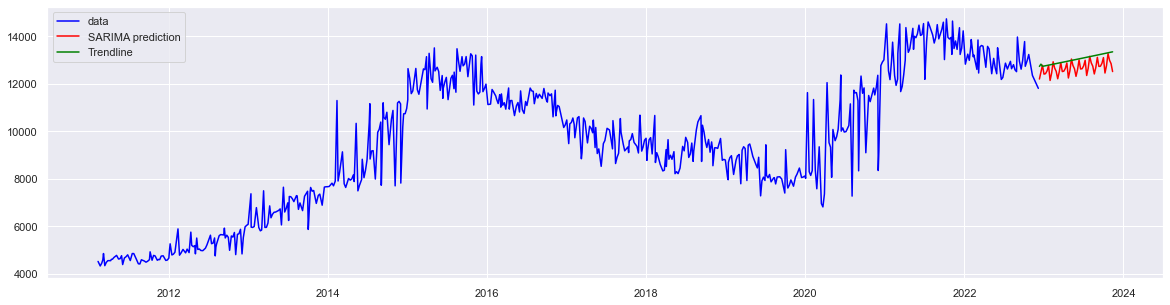

In [239]:
plt.figure(figsize=(20,5)) 

plt.plot(df_nipharm_ret.price, color='blue', label='data')
plt.plot(y_pred_out, color='red', label='SARIMA prediction')
plt.plot(y_pred_out_2, color='green', label='Trendline')

plt.legend()
plt.show()